In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_acc
%store -r Y_relative_footsteps_acc
print(X_relative_footsteps_acc.shape)
print(Y_relative_footsteps_acc.shape)

(17646, 28)
(17646, 8)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_relative_footsteps_acc[:, 24] == 1)[0]
X_relative_footsteps_acc_RR_swing = X_relative_footsteps_acc[idxs]
Y_relative_footsteps_acc_RR_swing = Y_relative_footsteps_acc[idxs]

## Predict FL foot -> x

In [8]:
X_relative_footsteps_acc_RR_swing[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.04003644, -0.06632428,
        0.05440154,  0.00439207,  0.02899047,  0.02653936,  0.22664036,
        0.18001143, -0.4086564 ,  0.23994108, -0.16991884, -0.40835668,
       -0.2385218 ,  0.16382314, -0.41169444, -0.25160387, -0.15317046,
       -0.41252498,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ])

In [9]:
Y_relative_footsteps_acc_RR_swing[0, :]

array([ 0.22800851,  0.17177425,  0.23270544, -0.17693889, -0.24620022,
        0.1547656 , -0.24999362, -0.16156544])

### Linear Regression

In [26]:
# Input
X = np.hstack((X_relative_footsteps_acc_RR_swing[:, :3], # prev velocity command
               X_relative_footsteps_acc_RR_swing[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_RR_swing[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_RR_swing[:, 6]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8588479708778659
RMSE:  0.005673908160076405
The lowest error is:  2.12428978796364e-06
The highest error is:  0.05169497055750266
The avg. error is:  0.002972009766197044


In [27]:
model_rr_relative_swinging_x.coef_

array([[ 0.00297236,  0.0010635 , -0.01327839,  0.10505812, -0.00129393,
         0.00127863, -0.10770145, -0.02041676, -0.03315383, -0.07958078,
         0.10390234,  0.11916685,  0.42787035, -0.02966768]])

In [31]:
model_rr_relative_swinging_x.intercept_

array([-0.12096103])

Text(0, 0.5, 'Predictions')

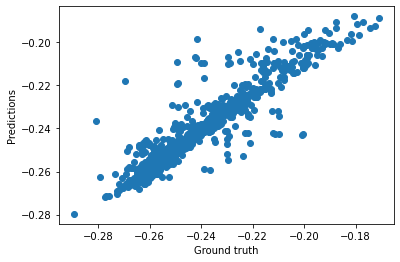

In [32]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [18]:
#%store model_rr_relative_swinging_x

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [20]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [34]:
# Input
X = np.hstack((X_relative_footsteps_acc_RR_swing[:, :3], # prev velocity command
               X_relative_footsteps_acc_RR_swing[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_RR_swing[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_RR_swing[:, 7]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9156725200059284
RMSE:  0.008864200707133072
The lowest error is:  1.4466475385666033e-06
The highest error is:  0.05186417532960745
The avg. error is:  0.0057555400279399645


In [35]:
model_rr_relative_swinging_y.coef_

array([[ 0.02214655, -0.02275158,  0.03210138, -0.00209331,  0.10192995,
         0.12314313, -0.13457132,  0.08182237,  0.28536417,  0.48785319,
        -0.47519191,  0.01509147,  0.17235955,  0.60274951]])

In [38]:
model_rr_relative_swinging_y.intercept_

array([-0.11290733])

Text(0, 0.5, 'Predictions')

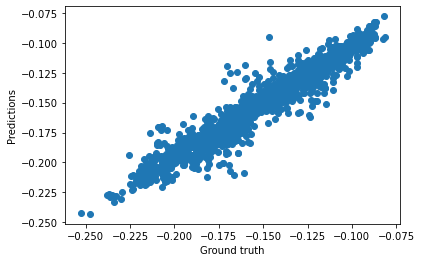

In [37]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_rr_relative_swinging_y

In [30]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [31]:
# Save model
#joblib.dump(model_rr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_y.sav")